# Практическое задание по занятию Denosing Diffusional Models

ФИО:

## Задание

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2) Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance https://arxiv.org/abs/2207.12598. (2 балла)

3) Обучите модель в режиме inpainting. Параграф 4.1 в https://arxiv.org/pdf/2201.09865.pdf . (1 балл)


### Перепишем реализацию модели из репозитория

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision import transforms
import math
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value


class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x


# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [3]:
class DiffSet(Dataset):
    def __init__(self, train, dataset="MNIST"):
        transform = transforms.Compose([transforms.ToTensor()])

        datasets = {
            "MNIST": MNIST,
            "Fashion": FashionMNIST,
            "CIFAR": CIFAR10,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train, transform=transform
        )

        self.dataset_len = len(train_dataset.data)

        if dataset == "MNIST" or dataset == "Fashion":
            pad = transforms.Pad(2)
            data = pad(train_dataset.data)
            data = data.unsqueeze(3)
            self.depth = 1
            self.size = 32
        elif dataset == "CIFAR":
            data = torch.Tensor(train_dataset.data)
            self.depth = 3
            self.size = 32
        self.input_seq = ((data / 255.0) * 2.0) - 1.0
        self.input_seq = self.input_seq.moveaxis(3, 1)

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, item):
        return self.input_seq[item]


In [4]:
class DiffusionModel(pl.LightningModule):
    def __init__(self, in_size, t_range, img_depth):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.in_size = in_size

        bilinear = True
        self.inc = DoubleConv(img_depth, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, img_depth)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

    def beta(self, t):
        return self.beta_small + (t / self.t_range) * (
            self.beta_large - self.beta_small
        )

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        return math.prod([self.alpha(j) for j in range(t)])

    def get_loss(self, batch, batch_idx):
        """
        Corresponds to Algorithm 1 from (Ho et al., 2020).
        """
        ts = torch.randint(0, self.t_range, [batch.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(batch.shape, device=self.device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float))
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss

    def denoise_sample(self, x, t):
        """
        Corresponds to the inner loop of Algorithm 2 from (Ho et al., 2020).
        """
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x.shape)
            else:
                z = 0
            e_hat = self.forward(x, t.view(1, 1).repeat(x.shape[0], 1))
            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("val/loss", loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer


# Задание 1. Обучите модель для датасета Fasion MNIST.  
 Продемонстрируйте обратный диффузионный процесс с нескольких random seeds

In [5]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1

torch.set_float32_matmul_precision("high")

In [6]:
pass_version = None
last_checkpoint = None

In [7]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Create model and trainer

model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

In [8]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    logger=tb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
# Train model
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type       | Params | Mode 
----------------------------------------------
0  | inc   | DoubleConv | 37.7 K | train
1  | down1 | Down       | 295 K  | train
2  | down2 | Down       | 1.2 M  | train
3  | down3 | Down       | 2.4 M  | train
4  | up1   | Up         | 6.2 M  | train
5  | up2   | Up         | 1.5 M  | train
6  | up3   | Up         | 406 K  | train
7  | outc  | OutConv    | 65     | train
8  | sa1   | SAWrapper  | 395 K  | train
9  | sa2   | SAWrapper  | 395 K  | train
10 | sa3   | SAWrapper  | 99.6 K | train
----------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Посмотрим на результаты генерации

In [10]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10

# Generate samples from denoising process
gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range-1, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

In [11]:
gen_samples = gen_samples.reshape(-1, train_dataset.size, train_dataset.size, train_dataset.depth)

if train_dataset.depth == 1:
    gen_samples = gen_samples.squeeze(-1)  # Убираем лишнее измерение для черно-белых изображений

frames = [frame.numpy() for frame in gen_samples]

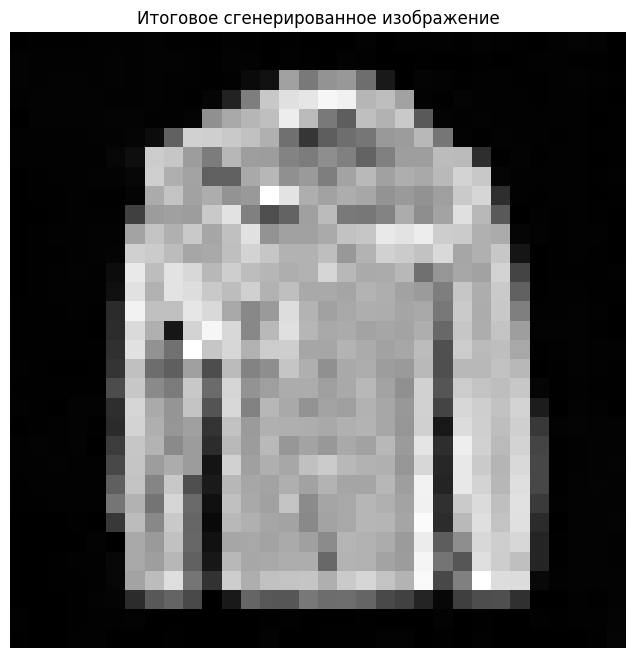

In [12]:
import matplotlib.pyplot as plt

final_image = gen_samples[-3]
final_image = final_image.squeeze()
final_image = (final_image * 255).type(torch.uint8).numpy() 

plt.figure(figsize=(8, 8))
if final_image.ndim == 3 and final_image.shape[-1] == 1:
    plt.imshow(final_image[:, :, 0], cmap='gray')
elif final_image.ndim == 2:
    plt.imshow(final_image, cmap='gray')
else:
    plt.imshow(final_image)
plt.axis('off')
plt.title("Итоговое сгенерированное изображение")
plt.show()

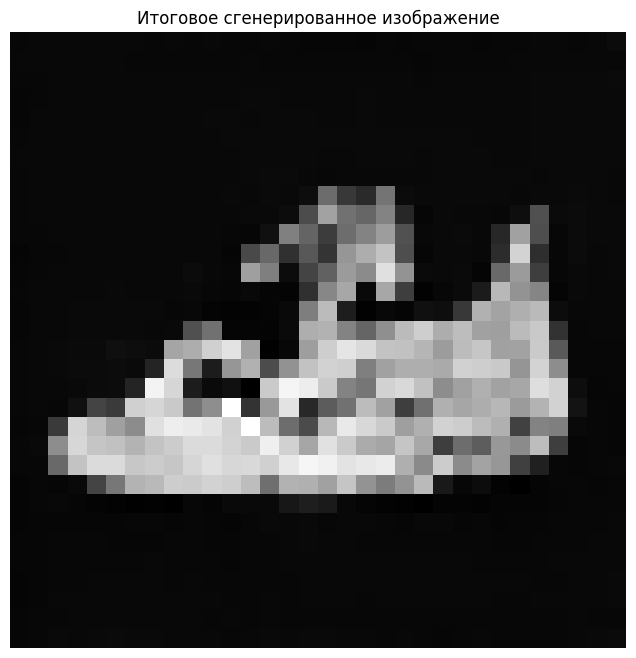

In [26]:
import matplotlib.pyplot as plt

sample_batch_size = 1 
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))

sample_steps = torch.arange(model.t_range-1, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t)

final_image = (x.squeeze().clamp(-1, 1) + 1) / 2 
final_image = (final_image * 255).type(torch.uint8).numpy()

plt.figure(figsize=(8, 8))
if final_image.ndim == 3 and final_image.shape[-1] == 1:
    plt.imshow(final_image[:, :, 0], cmap='gray')
elif final_image.ndim == 2:
    plt.imshow(final_image, cmap='gray')
else:
    plt.imshow(final_image)
plt.axis('off')
plt.title("Итоговое сгенерированное изображение")
plt.show()


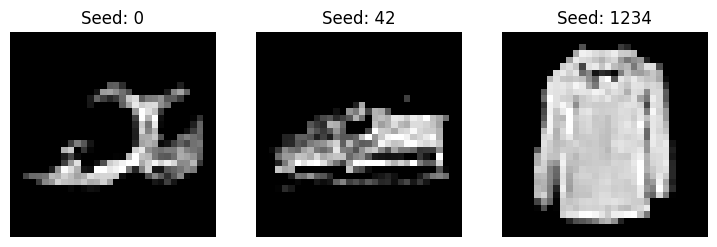

In [27]:
import matplotlib.pyplot as plt

seeds = [0, 42, 1234]
all_final_images = []

for s in seeds:
    torch.manual_seed(s)
    x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in sample_steps:
        x = model.denoise_sample(x, t)
    final_image = x[-1]
    all_final_images.append(final_image)

fig, axes = plt.subplots(1, len(seeds), figsize=(3*len(seeds),3))
for ax, img, sd in zip(axes, all_final_images, seeds):
    img_disp = (img.clamp(-1, 1) + 1) / 2
    img_disp = img_disp.squeeze().detach().cpu().numpy()
    ax.imshow(img_disp, cmap='gray')
    ax.set_title(f"Seed: {sd}")
    ax.axis('off')
plt.show()

# Задание 2. Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance


В данном пункте мы расширим обучение модели диффузии условием на метку класса.  
Для реализации classifier-free guidance, мы будем использовать идею из https://arxiv.org/abs/2207.12598:
- С вероятностью p часть батча мы будем заменять на «безметочный» вариант, т.е. условие отсутствует.
- Во время генерации мы сможем интерполировать условный и безусловный прогноз, тем самым управляя степенью "направления" (guidance).

In [40]:
class DiffSetWithLabels(DiffSet):
    def __init__(self, train, dataset="MNIST"):
        super().__init__(train, dataset)

        transform = transforms.Compose([transforms.ToTensor()])
        datasets = {
            "MNIST": MNIST,
            "Fashion": FashionMNIST,
            "CIFAR": CIFAR10,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train, transform=transform
        )
        self.labels = torch.tensor(train_dataset.targets if hasattr(train_dataset, 'targets') else train_dataset.labels)

    def __getitem__(self, idx):
        img = self.input_seq[idx]
        label = self.labels[idx]
        return img, label

In [47]:

class CondDiffusionModel(DiffusionModel):
    def __init__(self, in_size, t_range, img_depth, num_classes=10, class_emb_dim=128, guidance_prob=0.1):
        super().__init__(in_size, t_range, img_depth)
        self.num_classes = num_classes
        self.class_emb = nn.Embedding(num_classes, class_emb_dim)
        self.null_emb = nn.Parameter(torch.zeros(1, class_emb_dim))
        self.guidance_prob = guidance_prob

        self.image_size = int(math.sqrt(in_size))
        
        self.class_proj = nn.Sequential(
            nn.Linear(class_emb_dim, self.image_size*self.image_size)
        )

    def forward_model(self, x, t, class_vec=None):
        B = x.shape[0]
        if class_vec is not None:
            class_features = self.class_proj(class_vec)  # (B,1)
            class_features = class_features.view(B, 1, self.image_size, self.image_size)
            x = torch.cat([x, class_features], dim=1)
        else:
            zero_feat = torch.zeros(B,1,self.image_size,self.image_size, device=x.device)
            x = torch.cat([x, zero_feat], dim=1)
    
        return self.cond_unet(x, t)

    def get_loss(self, batch, batch_idx):
        imgs, labels = batch  #  (img, label)
        mask = torch.rand(labels.size(), device=self.device) < self.guidance_prob
        # Для безусловных примеров используем null_emb, для остальных class_emb
        class_embeddings = torch.zeros((labels.size(0), self.class_emb.embedding_dim), device=self.device)
        class_embeddings[mask] = self.null_emb
        class_embeddings[~mask] = self.class_emb(labels[~mask])

        ts = torch.randint(0, self.t_range, [imgs.shape[0]], device=self.device)
        epsilons = torch.randn(imgs.shape, device=self.device)

        noise_imgs = []
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * imgs[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        # Прогон через модель с учетом класса
        e_hat = self.forward_model(noise_imgs, ts.unsqueeze(-1).type(torch.float), class_embeddings)
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss

    def denoise_sample_guided(self, x, t, class_label=None, guidance_scale=5.0):
        with torch.no_grad():
            # безусловное предсказание
            e_hat_uncond = self.forward_model(x, t.view(1, 1).repeat(x.shape[0], 1),
                                              self.null_emb.repeat(x.shape[0], 1))
            # условное предсказание
            if class_label is not None:
                class_emb = self.class_emb(torch.tensor([class_label] * x.shape[0], device=self.device))
            else:
                class_emb = self.null_emb.repeat(x.shape[0], 1)
            e_hat_cond = self.forward_model(x, t.view(1, 1).repeat(x.shape[0], 1), class_emb)

            e_hat = e_hat_uncond + guidance_scale * (e_hat_cond - e_hat_uncond)

            if t > 1:
                z = torch.randn_like(x)
            else:
                z = 0
            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

In [48]:
class CondUNet(DiffusionModel):
    def __init__(self, in_size, t_range, img_depth):
        super().__init__(in_size, t_range, img_depth)

        bilinear = True
        self.inc = DoubleConv(img_depth + 1, 64)  # вход теперь img_depth+1

    def forward(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

In [49]:
class FullCondDiffusionModel(CondDiffusionModel):
    def __init__(self, in_size, t_range, img_depth, num_classes=10, class_emb_dim=128, guidance_prob=0.1):
        super().__init__(in_size, t_range, img_depth, num_classes, class_emb_dim, guidance_prob)
        self.cond_unet = CondUNet(in_size, t_range, img_depth)
        self.image_size = int(math.sqrt(in_size))

    def forward_model(self, x, t, class_vec=None):
        if class_vec is not None:
            class_features = self.class_proj(class_vec)  # (B,pixels)
            B = x.shape[0]
            class_features = class_features.view(B, 1, self.image_size, self.image_size)
            x = torch.cat([x, class_features], dim=1)
        else:
            # Если нет вектора класса, просто добавляем канал нулей
            B = x.shape[0]
            zero_feat = torch.zeros(B, 1, self.image_size, self.image_size, device=x.device)
            x = torch.cat([x, zero_feat], dim=1)
        return self.cond_unet(x, t)

In [56]:
diffusion_steps_cond = 200
max_epoch_cond = 5
batch_size_cond = 128
dataset_choice_cond = "Fashion"

train_dataset_cond = DiffSetWithLabels(True, dataset_choice_cond)
val_dataset_cond = DiffSetWithLabels(False, dataset_choice_cond)

train_loader_cond = DataLoader(train_dataset_cond, batch_size=batch_size_cond, shuffle=True)
val_loader_cond = DataLoader(val_dataset_cond, batch_size=batch_size_cond, shuffle=False)

cond_model = FullCondDiffusionModel(train_dataset_cond.size * train_dataset_cond.size, diffusion_steps_cond,
                                    train_dataset_cond.depth)

tb_logger_cond = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice_cond + "_cond",
)

trainer_cond = pl.Trainer(
    max_epochs=max_epoch_cond,
    log_every_n_steps=10,
    logger=tb_logger_cond
)

trainer_cond.fit(cond_model, train_loader_cond, val_loader_cond)

C:\Users\zacgr\AppData\Local\Temp\ipykernel_9724\3562888579.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(train_dataset.targets if hasattr(train_dataset, 'targets') else train_dataset.labels)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type       | Params | Mode 
-----------------------------------------------------
0  | inc          | DoubleConv | 37.7 K | train
1  | down1        | Down       | 295 K  | train
2  | down2        | Down       | 1.2 M  | train
3  | down3        | Down       | 2.4 M  | train
4  | up1          | Up         | 6.2 M  | train
5  | up2          | Up         | 1.5 M  | train
6  | up3          | Up         | 406 K  | train
7  | outc         | OutCo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


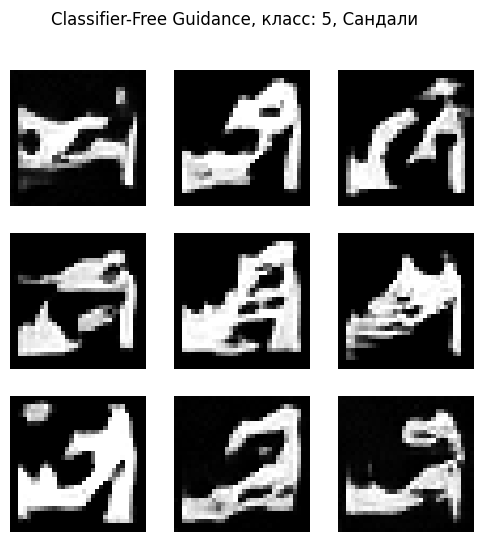

In [59]:
cond_model.eval()
torch.manual_seed(0)
sample_class = 5  # Сандали
x = torch.randn((9, train_dataset_cond.depth, train_dataset_cond.size, train_dataset_cond.size))
sample_steps = torch.arange(cond_model.t_range - 1, 0, -1)
for t in sample_steps:
    x = cond_model.denoise_sample_guided(x, t, class_label=sample_class, guidance_scale=5.0)

gen_image = (x.clamp(-1, 1) + 1) / 2
gen_image = gen_image.squeeze().detach().cpu().numpy()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img_disp = gen_image[i]
    ax.imshow(img_disp, cmap='gray')
    ax.axis('off')
plt.suptitle(f"Classifier-Free Guidance, класс: {sample_class}, Сандали")
plt.show()

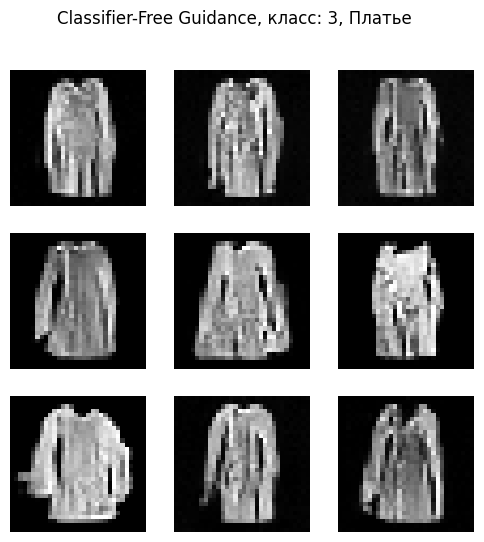

In [54]:
cond_model.eval()
torch.manual_seed(0)
sample_class = 3  # Платье
x = torch.randn((9, train_dataset_cond.depth, train_dataset_cond.size, train_dataset_cond.size))
sample_steps = torch.arange(cond_model.t_range - 1, 0, -1)
for t in sample_steps:
    x = cond_model.denoise_sample_guided(x, t, class_label=sample_class, guidance_scale=5.0)

gen_image = (x.clamp(-1, 1) + 1) / 2
gen_image = gen_image.squeeze().detach().cpu().numpy()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img_disp = gen_image[i]
    ax.imshow(img_disp, cmap='gray')
    ax.axis('off')
plt.suptitle(f"Classifier-Free Guidance, класс: {sample_class}, Платье")
plt.show()

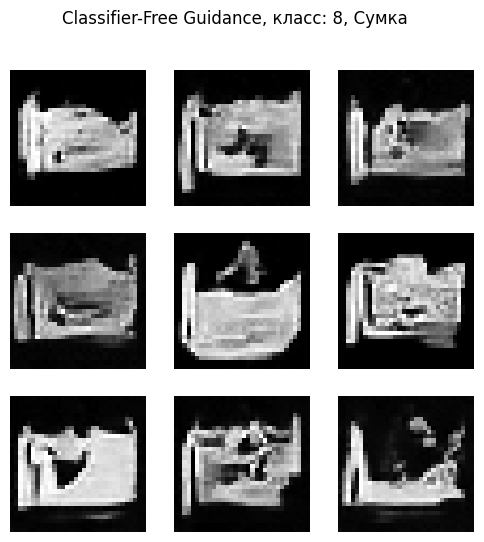

In [55]:
cond_model.eval()
torch.manual_seed(0)
sample_class = 8  # Сумка
x = torch.randn((9, train_dataset_cond.depth, train_dataset_cond.size, train_dataset_cond.size))
sample_steps = torch.arange(cond_model.t_range - 1, 0, -1)
for t in sample_steps:
    x = cond_model.denoise_sample_guided(x, t, class_label=sample_class, guidance_scale=5.0)

gen_image = (x.clamp(-1, 1) + 1) / 2
gen_image = gen_image.squeeze().detach().cpu().numpy()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img_disp = gen_image[i]
    ax.imshow(img_disp, cmap='gray')
    ax.axis('off')
plt.suptitle(f"Classifier-Free Guidance, класс: {sample_class}, Сумка")
plt.show()

Как видно, условная генерация работает

# Задание 3. Обучите модель в режиме inpainting

В процессе обучения мы будем "маскировать" часть изображения (например, центральный квадратик) и требовать от модели восстановить исходное изображение,  
при этом используя диффузионную модель как реставратор.  

Для этого нам понадобится модифицировать датасет так, чтобы он возвращал не только оригинальное изображение,  
но и "зашумленное/маскированное" изображение, а также маску, показывающую, какие пиксели скрыты.  

Модель будет принимать на вход зашумленное изображение с пропусками и пытаться предсказать шум таким образом,  
чтобы восстановить исходный сигнал.  

По сути, при обучении мы будем подавать модель через тот же механизм, но входное изображение будет частично затёрто маской (например, заполненной шумом).  

In [64]:
class InpaintDataset(DiffSet):
    def __init__(self, train, dataset="MNIST", mask_size=8):
        super().__init__(train, dataset)
        self.mask_size = mask_size
        self.center = (self.size // 2, self.size // 2)
        half = mask_size // 2
        self.start = self.center[0] - half
        self.end = self.center[0] + half

    def __getitem__(self, idx):
        img = self.input_seq[idx].clone()
        mask = torch.ones_like(img)
        mask[:, self.start:self.end, self.start:self.end] = 0.0
        # Зашумляем замаскированную область
        noised_img = img.clone()
        noised_img[:, self.start:self.end, self.start:self.end] = torch.randn_like(
            noised_img[:, self.start:self.end, self.start:self.end]) * 0.5
        return img, noised_img, mask

In [65]:
class InpaintDiffusionModel(DiffusionModel):
    def alpha_bar(self, t):
        # Приводим t к int
        t_int = int(t.item()) if hasattr(t, 'item') else t
        return math.prod([self.alpha(j) for j in range(t_int)])
    
    def get_loss(self, batch, batch_idx):
        orig, noised_img, mask = batch
        ts = torch.randint(0, self.t_range, [orig.shape[0]], device=self.device)
        epsilons = torch.randn(orig.shape, device=self.device)

        noise_imgs = []
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noisy = (math.sqrt(a_hat) * orig[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            # На вход модели подаем смешанное изображение: в известных областях noisy, в замаскированных - noised_img
            inp = noisy * mask[i] + noised_img[i] * (1 - mask[i])
            noise_imgs.append(inp)
        noise_imgs = torch.stack(noise_imgs, dim=0)

        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float))
        loss = nn.functional.mse_loss(e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size))
        return loss

    @torch.no_grad()
    def inpaint_sample(self, noised_img, mask):
        x = noised_img.clone()
        steps = torch.arange(self.t_range - 1, 0, -1, device=self.device)
        for t in steps:
            t_int = int(t.item())
            if t_int > 1:
                z = torch.randn_like(x)
            else:
                z = 0
            
            e_hat = self.forward(x, t.view(1,1).float())
            
            a_t = self.alpha(t_int)
            ab_t = self.alpha_bar(t_int)
            b_t = self.beta(t_int)

            pre_scale = 1 / math.sqrt(a_t)
            e_scale = (1 - a_t) / math.sqrt(1 - ab_t)
            post_sigma = math.sqrt(b_t) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma

            x = x * mask + noised_img * (1 - mask)
        return x

In [66]:
inpaint_steps = 200
max_epoch_inpaint = 5
batch_size_inpaint = 128
dataset_choice_inpaint = "Fashion"

inpaint_train_dataset = InpaintDataset(True, dataset_choice_inpaint, mask_size=8)
inpaint_val_dataset = InpaintDataset(False, dataset_choice_inpaint, mask_size=8)

inpaint_train_loader = DataLoader(inpaint_train_dataset, batch_size=batch_size_inpaint, shuffle=True)
inpaint_val_loader = DataLoader(inpaint_val_dataset, batch_size=batch_size_inpaint, shuffle=False)

inpaint_model = InpaintDiffusionModel(inpaint_train_dataset.size * inpaint_train_dataset.size, inpaint_steps,
                                      inpaint_train_dataset.depth)

tb_logger_inpaint = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice_inpaint + "_inpaint",
)

trainer_inpaint = pl.Trainer(
    max_epochs=max_epoch_inpaint,
    log_every_n_steps=10,
    logger=tb_logger_inpaint
)

trainer_inpaint.fit(inpaint_model, inpaint_train_loader, inpaint_val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type       | Params | Mode 
----------------------------------------------
0  | inc   | DoubleConv | 37.7 K | train
1  | down1 | Down       | 295 K  | train
2  | down2 | Down       | 1.2 M  | train
3  | down3 | Down       | 2.4 M  | train
4  | up1   | Up         | 6.2 M  | train
5  | up2   | Up         | 1.5 M  | train
6  | up3   | Up         | 406 K  | train
7  | outc  | OutConv    | 65     | train
8  | sa1   | SAWrapper  | 395 K  | train
9  | sa2   | SAWrapper  | 395 K  | train
10 | sa3   | SAWrapper  | 99.6 K | train
----------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


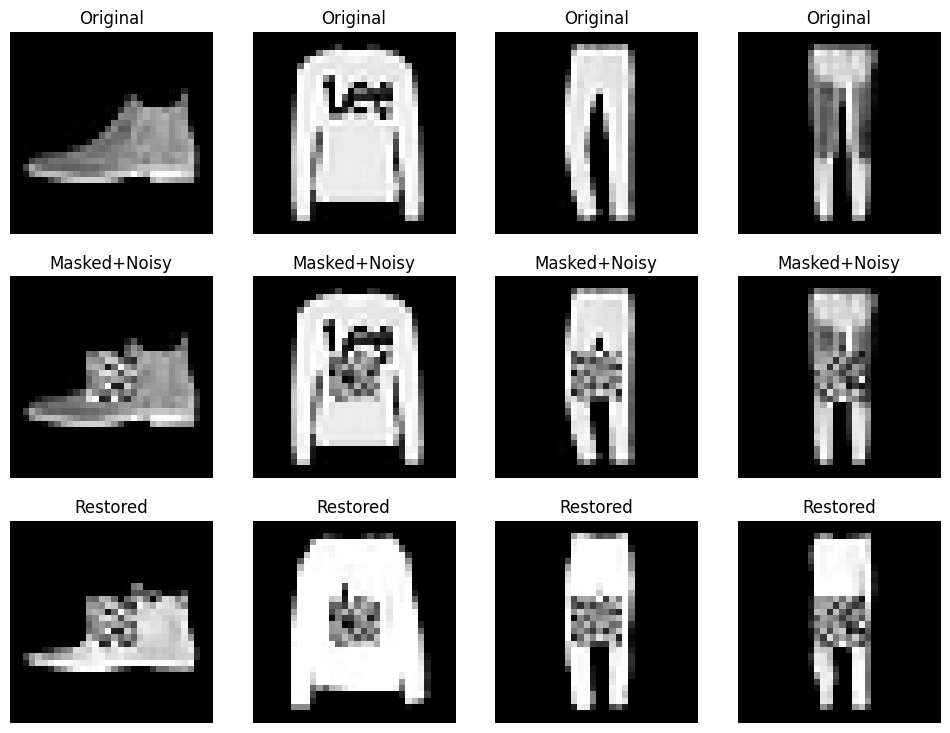

In [67]:
inpaint_model.eval()
torch.manual_seed(0)
sample_batch_size = 4
orig, noised_img, mask = next(iter(inpaint_val_loader))
orig = orig[:sample_batch_size].to(inpaint_model.device)
noised_img = noised_img[:sample_batch_size].to(inpaint_model.device)
mask = mask[:sample_batch_size].to(inpaint_model.device)

restored = inpaint_model.inpaint_sample(noised_img, mask)

orig_disp = (orig.clamp(-1, 1) + 1) / 2
noised_disp = (noised_img.clamp(-1, 1) + 1) / 2
restored_disp = (restored.clamp(-1, 1) + 1) / 2

orig_disp = orig_disp.squeeze().detach().cpu().numpy()
noised_disp = noised_disp.squeeze().detach().cpu().numpy()
restored_disp = restored_disp.squeeze().detach().cpu().numpy()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sample_batch_size, figsize=(3 * sample_batch_size, 9))
for i in range(sample_batch_size):
    axes[0, i].imshow(orig_disp[i], cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(noised_disp[i], cmap='gray')
    axes[1, i].set_title('Masked+Noisy')
    axes[1, i].axis('off')

    axes[2, i].imshow(restored_disp[i], cmap='gray')
    axes[2, i].set_title('Restored')
    axes[2, i].axis('off')

plt.show()

Ну, какой-то результат всё же есть, возможно нужно обучать сильно дольше

Выводы: Я познакомился с возможностями применения и особенностями диффузионных моделей. Получил вменяемые результаты генерации.